# Evaluation of multi-omics GRN inference methods
## Benchmarking of the inferred GRNs
### by Jalil Nourisa



## Imports

In [105]:
# !pip install anndata lightgbm

In [106]:
# !conda install -c conda-forge graph-tool -y 

In [107]:
import os
import gzip
import pandas as pd
import numpy as np
import anndata as ad
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn
import tqdm
import scipy
import json
import sys

sys.path.insert(0, '../')
from src.commons import format_folder, work_dir, COLORS, surragate_names, LINESTYLES, MARKERS

os.environ['KMP_DUPLICATE_LIB_OK']='True'

results_folder = '../results_folder/regression_1' # where to store the results summary
os.makedirs(results_folder, exist_ok=True)

datasets = ['pearson', 'lognorm', 'seurat_pearson', 'seurat_lognorm', 'scgen_pearson', 'scgen_lognorm'] # ['seurat_lognorm', 'scgen_pearson']
grn_models = ['negative_control', 'collectRI', 'granie', 'celloracle', 'figr', 'scglue', 'scenicplus', 'positive_control']


In [108]:
def extract_table(reg_type, exclude_missing_genes, manipulate, theta, tf_n, subsample, datasets, grn_models):
    mat = []
    for i_plot, norm_method in enumerate(datasets):
        row = []
        for grn_model in grn_models:
            file = f'{format_folder(work_dir, exclude_missing_genes, reg_type, theta, tf_n, norm_method, subsample)}/{grn_model}_{manipulate}.json'
            if not os.path.exists(file):
                print(f'Missing file: {file}')
                mean_score = np.nan
            else:
                with open(file, 'r') as f:
                    data = json.load(f)
                mean_score = data['mean_score_r2']
            row.append(mean_score)
        mat.append(row)
    mat = np.asarray(mat)
    mat_df = pd.DataFrame(mat, index=[surragate_names[label] for label in datasets], columns=[surragate_names[label] for label in grn_models])

    mat_df.loc['Mean'] = mat_df.mean(axis=0)
    return mat_df 

## Experiment with thetas

In [109]:
# experiment='theta'
# reg_type = 'GB'
# subsample = 200
# !python ../src/regression.py --experiment {experiment} --reg_type {reg_type} --subsample {subsample}

In [110]:
# summarize the results
subsample = 200

manipulate = None
exclude_missing_genes = False
tf_n = None
reg_type = 'GB'
norm_method = 'scgen_pearson'

thetas = np.linspace(0, 1, 5)
rr = pd.DataFrame(columns=thetas)
for method in grn_models:

    series = []
    for theta in thetas:
        file =  f'{format_folder(work_dir, exclude_missing_genes, reg_type, theta, tf_n, norm_method, subsample)}/{method}_{manipulate}.json'
        if not os.path.exists(file):
            print(f'Missing file: {file}')
            mean_score = np.nan
        else:
            with open(file, 'r') as f:
                data = json.load(f)
            mean_score = data['mean_score_r2']

        series.append(float(mean_score))
    rr.loc[method] = series
rr.index = rr.index.map(surragate_names)
rr.to_csv(f'{results_folder}/thetas_experiment.csv')
rr.head()

,0.00,0.25,0.50,0.75,1.00
Negative Control,-0.000359,-0.003731,-0.009014,-0.009259,-0.013344
CollectRI,0.006545,0.023109,0.015580,0.021619,0.019452
GRANIE,0.003097,0.058889,0.063704,0.059381,0.063279
CellOracle,0.097950,0.252415,0.269051,0.261371,0.272837
FigR,0.009723,0.056390,0.051656,0.052194,0.053217


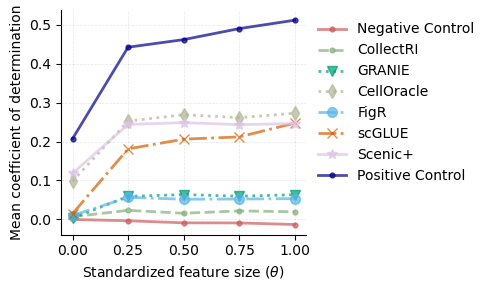

In [111]:
thetas_experiment = pd.read_csv(f'{results_folder}/thetas_experiment.csv', index_col=0)

def line_plot_theta(ax, results_df):
    markersize = 7
    linewidth = 2

    ax.grid(alpha=0.2, linewidth=.5, color='grey', linestyle='--')
    xs = np.linspace(0, 1, 5)
    for method, series in results_df.iterrows():        
        ax.plot(
            xs, series, label=method, color=COLORS[method], markersize=markersize,
            linestyle=LINESTYLES[method], marker=MARKERS[method], alpha=0.7, linewidth=linewidth
        )

    ax.set_xticks(xs)
    # ax.set_title(f'{surragate_names[norm_method]} ({reg_type})')
    ax.set_ylabel('Mean coefficient of determination')
    
        
    for side in ['right', 'top']:
        ax.spines[side].set_visible(False)
    ax.set_xlabel(r'Standardized feature size ($\theta$)')
    ax.legend(loc='upper left', bbox_to_anchor=(1,1), frameon=False)


fig, ax = plt.subplots(1, 1, figsize=(5, 3))

line_plot_theta(ax, thetas_experiment)
plt.tight_layout()
plt.savefig(f'{results_folder}/figs/first-validation-performance-theta.png', dpi=300, transparent=True)
plt.show()

## All datasets , 200 subsample
run for all datasets for a subsample of 200 from 2100 samples


In [112]:
# experiment = 'default'
# reg_type = 'GB'
# subsample=200 
# !python ../src/regression.py --experiment {experiment} --reg_type {reg_type} --subsample {subsample} 
# !python ../src/regression.py --experiment {experiment} --reg_type {reg_type} --subsample {subsample} --exclude-missing-genes

In [113]:
# summarize results
manipulate=None
subsample=200
theta = 1.0
tf_n = None


df_table = extract_table('GB', exclude_missing_genes=False, manipulate=manipulate, theta=theta, tf_n=tf_n, subsample=subsample, datasets=datasets, grn_models=grn_models)
df_table.to_csv(f'{results_folder}/table_all_datasets_200.csv')
df_table = extract_table('GB', exclude_missing_genes=True, manipulate=manipulate, theta=theta, tf_n=tf_n, subsample=subsample, datasets=datasets, grn_models=grn_models)
df_table.to_csv(f'{results_folder}/table_all_datasets_200_exclude.csv')

### plot heatmap

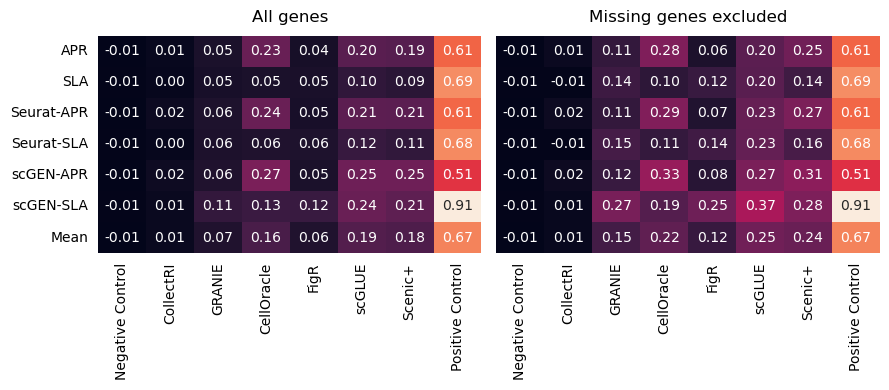

In [114]:
df_table = pd.read_csv(f'{results_folder}/table_all_datasets_200.csv', index_col=0)
df_table_exclude = pd.read_csv(f'{results_folder}/table_all_datasets_200_exclude.csv', index_col=0)

fig, axes = plt.subplots(1, 2, figsize=(9, 4), sharey=True)
combined_mat = np.concatenate((df_table.values.flatten(), df_table_exclude.values.flatten()))
vmin = np.nanmin(combined_mat)
vmax = np.nanmax(combined_mat)

for i, (name, mat_df) in enumerate(zip(['All genes', 'Missing genes excluded'], [df_table, df_table_exclude])):
    ax = axes[i]
    seaborn.heatmap(mat_df, ax=ax, square=False, cbar=False, annot=True, fmt='.2f', vmin=vmin, vmax=vmax)
    # Remove only the ticks, keep labels
    ax.tick_params(left=False, bottom=False)
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=0)
    ax.set_title(name, pad=10)


plt.tight_layout()

plt.savefig(f'{results_folder}/figs/first-validation-heatmap-subset.png', dpi=300, transparent=True,  bbox_inches='tight')


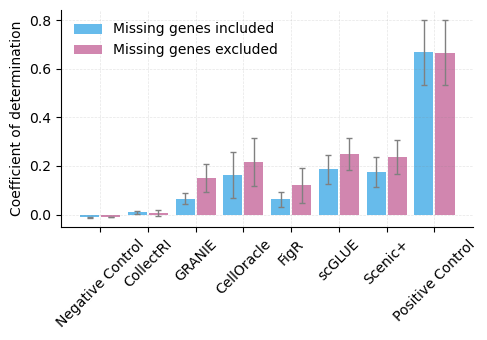

In [115]:
# bar plot

means_GB = df_table.loc['Mean']
stds_GB = df_table.drop('Mean').std(axis=0)

means_GB_exc = df_table_exclude.loc['Mean']
stds_GB_exc = df_table_exclude.drop('Mean').std(axis=0)

# Plotting
fig, ax = plt.subplots(figsize=(5, 3.5))

# Number of columns
n_cols = len(means_GB.index)

# X-axis positions
x = np.arange(n_cols)

# Width of the bars
width = 0.4
alpha = 0.9
colors = ['#56B4E9',  # Sky Blue
          '#CC79A7'] 
error_kw = dict(elinewidth=1, capsize=2, capthick=1, ecolor='grey')


bars1 = ax.bar(x - width/2-.02, means_GB, width, yerr=stds_GB,  label='Missing genes included', color=colors[0], alpha=alpha, error_kw=error_kw)
bars2 = ax.bar(x + width/2+.02, means_GB_exc, width, yerr=stds_GB_exc, label='Missing genes excluded', color=colors[1], alpha=alpha, error_kw=error_kw)

ax.set_ylabel('Coefficient of determination')
ax.set_xticks(x)
ax.set_xticklabels(means_GB.index, rotation=45)
ax.legend(frameon=False)
for side in ['right', 'top']:
    ax.spines[side].set_visible(False)
ax.grid(alpha=0.2, linewidth=.5, color='grey', linestyle='--')

plt.tight_layout()

plt.savefig(f'{results_folder}/figs/first-validation-variations.png', dpi=300, transparent=True,  bbox_inches='tight')
# plt.show()

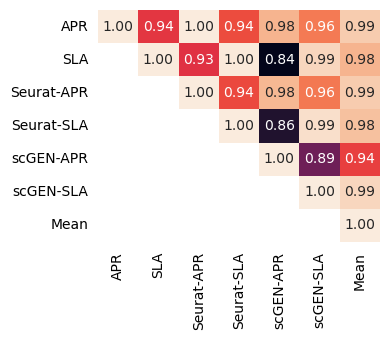

In [116]:
# correlation
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
# Calculate the minimum and maximum correlation values across both datasets
df_corr = df_table.T.corr().round(3)

# Combine both correlation matrices to find global min and max
vmin = np.nanmin(df_corr)
vmax = np.nanmax(df_corr)

fig, ax = plt.subplots(1, 1, figsize=(4, 3.5))

mask = np.tril(np.ones(df_corr.shape), k=-1).astype(bool)

# Apply the mask to set values below the diagonal to NaN
df_corr.where(~mask, other=np.nan, inplace=True)

sns.heatmap(df_corr, ax=ax, square=False, cbar=False, annot=True, fmt='.2f', vmin=vmin, vmax=vmax)

# Remove only the ticks, keep labels
ax.tick_params(left=False, bottom=False)
ax.xaxis.set_tick_params(width=0)
ax.yaxis.set_tick_params(width=0)

plt.tight_layout()
plt.savefig(f'{results_folder}/figs/datasets-correlation.png', dpi=300, transparent=True,  bbox_inches='tight')

## Full sample

In [117]:
# Run
# experiment = 'default'
# reg_type = 'GB'
# !python ../src/regression.py --experiment {experiment} --reg_type {reg_type} 
# !python ../src/regression.py --experiment {experiment} --reg_type {reg_type} --exclude-missing-genes

In [118]:
# summarize and save the results
manipulate=None
subsample=None
theta = 1.0
tf_n = None
mat_gb_exc = extract_table('GB', exclude_missing_genes=True, manipulate=manipulate, theta=theta, tf_n=tf_n, subsample=subsample, datasets=datasets, grn_models=grn_models)
mat_gb_exc.to_csv(f'{results_folder}/table_all_datasets_exclude.csv')

mat_gb = extract_table('GB', exclude_missing_genes=False, manipulate=manipulate, theta=theta, tf_n=tf_n, subsample=subsample, datasets=datasets, grn_models=grn_models)
mat_gb.to_csv(f'{results_folder}/table_all_datasets.csv')

Missing file: ../output/benchmark/scores/subsample_None/exclude_missing_genes_True/GB/theta_1.0_tf_n_None/seurat_pearson/negative_control_None.json
Missing file: ../output/benchmark/scores/subsample_None/exclude_missing_genes_True/GB/theta_1.0_tf_n_None/seurat_pearson/collectRI_None.json
Missing file: ../output/benchmark/scores/subsample_None/exclude_missing_genes_True/GB/theta_1.0_tf_n_None/seurat_pearson/granie_None.json
Missing file: ../output/benchmark/scores/subsample_None/exclude_missing_genes_True/GB/theta_1.0_tf_n_None/seurat_pearson/celloracle_None.json
Missing file: ../output/benchmark/scores/subsample_None/exclude_missing_genes_True/GB/theta_1.0_tf_n_None/seurat_pearson/figr_None.json
Missing file: ../output/benchmark/scores/subsample_None/exclude_missing_genes_True/GB/theta_1.0_tf_n_None/seurat_pearson/scglue_None.json
Missing file: ../output/benchmark/scores/subsample_None/exclude_missing_genes_True/GB/theta_1.0_tf_n_None/seurat_pearson/scenicplus_None.json
Missing file: .

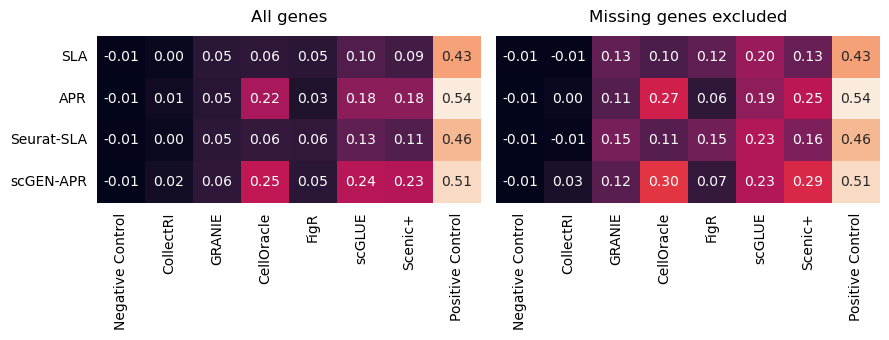

In [119]:
# plot
datasets = ['SLA', 'APR',  'Seurat-SLA', 'scGEN-APR']

df_table_exc = pd.read_csv(f'{results_folder}/table_all_datasets_exclude.csv', index_col=0)
df_table = pd.read_csv(f'{results_folder}/table_all_datasets.csv', index_col=0)

df_table = df_table.loc[datasets]
df_table_exc = df_table_exc.loc[datasets]

combined_mat = np.concatenate((df_table.values.flatten(), df_table_exc.values.flatten()))
vmin = np.nanmin(combined_mat)
vmax = np.nanmax(combined_mat)
fig, axes = plt.subplots(1, 2, figsize=(9, 3.5), sharey=True, sharex=True)

for i, (name, mat_df) in enumerate(zip(['All genes', 'Missing genes excluded'], [df_table, df_table_exc])):
    ax = axes[i]
    seaborn.heatmap(mat_df, ax=ax, square=False, cbar=False, annot=True, fmt='.2f', vmin=vmin, vmax=vmax)
    # Remove only the ticks, keep labels
    ax.tick_params(left=False, bottom=False)
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=0)
    ax.set_title(name, pad=10)


plt.tight_layout()

plt.savefig(f'{results_folder}/figs/first-validation-heatmap.png', dpi=300, transparent=True,  bbox_inches='tight')

### Correlation between subsample and full

In [120]:
import scipy.stats
reg_type = 'GB'

# plot
datasets = ['SLA', 'APR',  'Seurat-SLA', 'scGEN-APR']

mat = pd.read_csv(f'{results_folder}/table_all_datasets.csv', index_col=0).loc[datasets]
mat_exc = pd.read_csv(f'{results_folder}/table_all_datasets_exclude.csv', index_col=0).loc[datasets]


mat_sub =  pd.read_csv(f'{results_folder}/table_all_datasets_200.csv', index_col=0).loc[datasets]
mat_exc_sub =  pd.read_csv(f'{results_folder}/table_all_datasets_200_exclude.csv', index_col=0).loc[datasets]


mat = pd.concat([mat, mat_exc], axis=1)
mat_sub = pd.concat([mat_sub, mat_exc_sub], axis=1)

print(reg_type, scipy.stats.pearsonr(mat.values.flatten(), mat_sub.values.flatten()))

GB PearsonRResult(statistic=0.9723429652449572, pvalue=7.181456486572196e-41)


## Min feature space (TF_n=140)

In [121]:
# Run
# experiment = 'default'
# reg_type = 'GB'
# !python ../src/regression.py --experiment {experiment} --reg_type {reg_type} --tf_n 140
# !python ../src/regression.py --experiment {experiment} --reg_type {reg_type} --tf_n 140 --exclude-missing-genes

In [122]:
# read and summarize results
datasets=['scgen_pearson', 'seurat_lognorm']
mat_df0 = extract_table(reg_type='GB', exclude_missing_genes=False, manipulate=None, theta=1.0, tf_n=140, subsample=None, datasets=datasets, grn_models=grn_models)
mat_df0.to_csv(f'{results_folder}/table_all_datasets_tf0.csv')

mat_df0_exc = extract_table(reg_type='GB', exclude_missing_genes=True, manipulate=None, theta=1.0, tf_n=140, subsample=None, datasets=datasets, grn_models=grn_models)
mat_df0_exc.to_csv(f'{results_folder}/table_all_datasets_tf0_exclude.csv')


Missing file: ../output/benchmark/scores/subsample_None/exclude_missing_genes_False/GB/theta_1.0_tf_n_140/scgen_pearson/scenicplus_None.json
Missing file: ../output/benchmark/scores/subsample_None/exclude_missing_genes_False/GB/theta_1.0_tf_n_140/seurat_lognorm/scenicplus_None.json
Missing file: ../output/benchmark/scores/subsample_None/exclude_missing_genes_True/GB/theta_1.0_tf_n_140/scgen_pearson/scenicplus_None.json
Missing file: ../output/benchmark/scores/subsample_None/exclude_missing_genes_True/GB/theta_1.0_tf_n_140/seurat_lognorm/scenicplus_None.json


## Final scores 

In [123]:
datasets=['scGEN-APR', 'Seurat-SLA']

mat_g1_df0 = pd.read_csv(f'{results_folder}/table_all_datasets_tf0.csv', index_col=0).loc[datasets].mean(axis=0).to_frame(name='ex(False)_tf(140)')
mat_g1_df1 = pd.read_csv(f'{results_folder}/table_all_datasets.csv', index_col=0).loc[datasets].mean(axis=0).to_frame(name='ex(False)_tf(-1)')

mat_g1_df0.loc['Scenic+'] = mat_g1_df1.loc['Scenic+'].values

mat_g0_df1 = pd.read_csv(f'{results_folder}/table_all_datasets_exclude.csv', index_col=0).loc[datasets].mean(axis=0).to_frame(name='ex(True)_tf(140)')
mat_g0_df0 = pd.read_csv(f'{results_folder}/table_all_datasets_tf0_exclude.csv', index_col=0).loc[datasets].mean(axis=0).to_frame(name='ex(True)_tf(-1)')

mat_g0_df0.loc['Scenic+'] = mat_g0_df1.loc['Scenic+'].values

In [124]:
summary = pd.concat([ mat_g0_df0, mat_g0_df1, mat_g1_df0, mat_g1_df1], axis=1)
summary.to_csv(f'{results_folder}/summary.tsv', sep='\t')